# Dataset cleaning and visualizations
This notebook loads `dataset.csv`, performs exploratory data analysis (EDA), cleans the data, creates several visualizations (static + interactive), and saves a cleaned CSV as `dataset_cleaned.csv`.

Run the PowerShell command shown in the final cell to install required libraries before executing the notebook cells.

In [1]:
# Standard imports and load dataset
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import missingno as msno
from sklearn.impute import SimpleImputer

# display settings
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 200)

# load CSV (assumes file is in the same folder)
csv_path = 'dataset.csv'
assert os.path.exists(csv_path), f'File not found: {csv_path}'
df = pd.read_csv(csv_path)
print('Loaded', csv_path, 'with shape', df.shape)
df.head()

Loaded dataset.csv with shape (138, 7)


,location,num_rooms,gross,building_age,floor_type,furnishing_status,price
0,merkez,4,135,18,intermediate,0,6000
1,merkez,2,50,4,intermediate,1,5000
2,merkez,2,60,0,intermediate,0,6000
3,merkez,2,55,0,intermediate,0,6000
4,merkez,2,55,0,intermediate,0,6000


In [2]:
# Cleaning strategy (examples)
df_clean = df.copy()
# 1) Drop completely empty columns (if any)
threshold = int(0.95 * len(df_clean))
df_clean = df_clean.dropna(axis=1, thresh=threshold)
# 2) Drop rows where the target is missing (if there is a 'price' column as target)
target_candidates = ['price', 'Price', 'SalePrice']
target = next((c for c in target_candidates if c in df_clean.columns), None)
if target is not None:
    df_clean = df_clean.dropna(subset=[target])

# 3) Convert obvious numeric columns stored as objects
for col in df_clean.select_dtypes(include=['object']).columns:
    # try to coerce to numeric where >80% of non-null values are numeric-like
    coerced = pd.to_numeric(df_clean[col].dropna(), errors='coerce')
    num_ratio = coerced.notna().sum() / max(1, df_clean[col].notna().sum())
    if num_ratio > 0.8:
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

# 4) Impute numeric columns with median and categorical with mode
num_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df_clean.select_dtypes(include=['object', 'category']).columns.tolist()
if len(num_cols):
    num_imputer = SimpleImputer(strategy='median')
    df_clean[num_cols] = pd.DataFrame(num_imputer.fit_transform(df_clean[num_cols]), columns=num_cols)
if len(cat_cols):
    for c in cat_cols:
        if df_clean[c].isnull().any():
            df_clean[c] = df_clean[c].fillna(df_clean[c].mode().iloc[0])

# 5) Remove duplicate rows
df_clean = df_clean.drop_duplicates()

# 6) Basic outlier handling example: clip using IQR for numeric cols
def cap_iqr(series, k=1.5):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - k * iqr
    upper = q3 + k * iqr
    return series.clip(lower, upper)

for c in num_cols:
    if df_clean[c].dtype.kind in 'fi':
        df_clean[c] = cap_iqr(df_clean[c])

print('Before:', df.shape, 'After cleaning:', df_clean.shape)
df_clean.head()

Before: (138, 7) After cleaning: (133, 7)


,location,num_rooms,gross,building_age,floor_type,furnishing_status,price
0,merkez,4.0,135.0,18.0,intermediate,0.0,6000.0
1,merkez,2.0,50.0,4.0,intermediate,1.0,5000.0
2,merkez,2.0,60.0,0.0,intermediate,0.0,6000.0
3,merkez,2.0,55.0,0.0,intermediate,0.0,6000.0
5,merkez,2.0,55.0,7.0,intermediate,1.0,4000.0


Numeric columns: ['num_rooms', 'gross', 'building_age', 'furnishing_status', 'price']


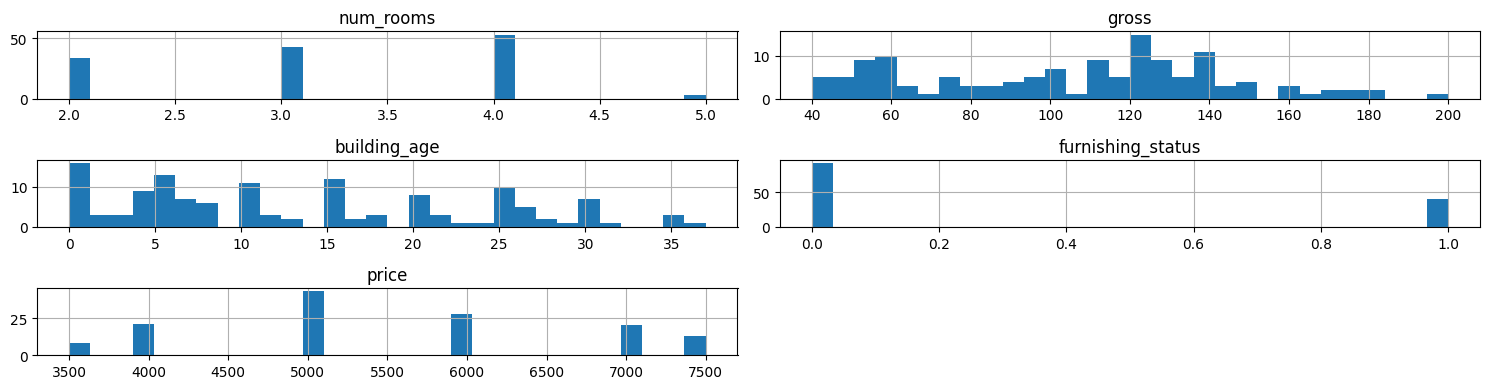

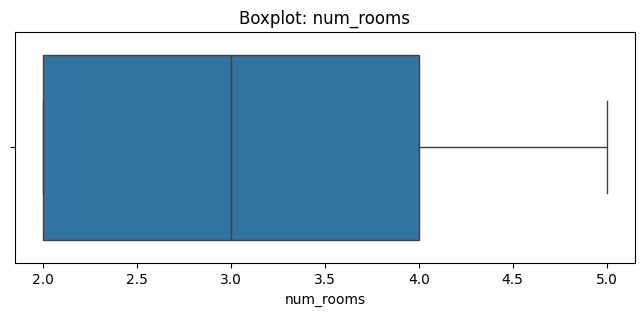

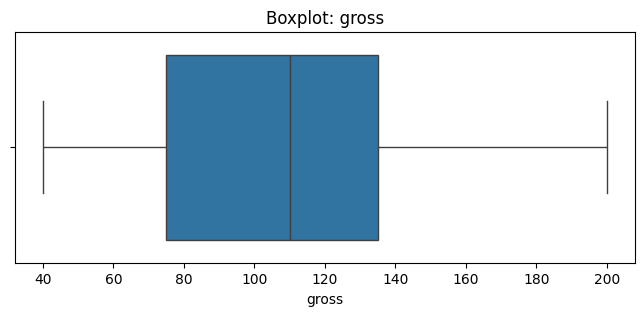

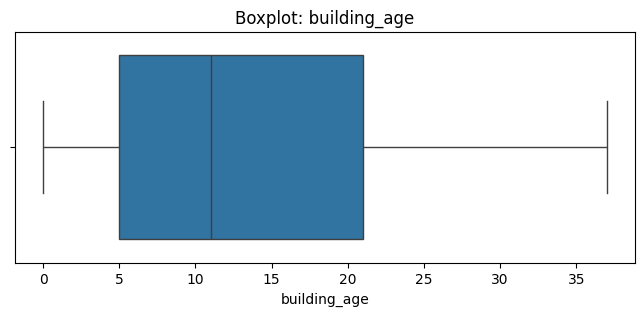

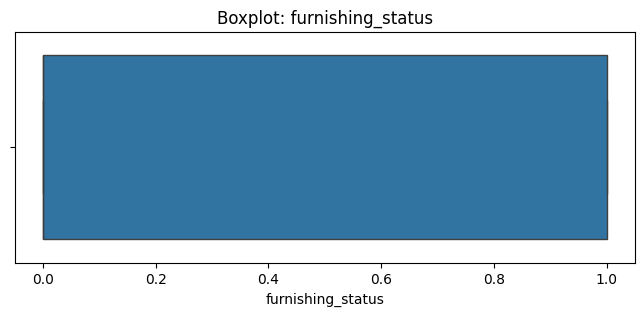

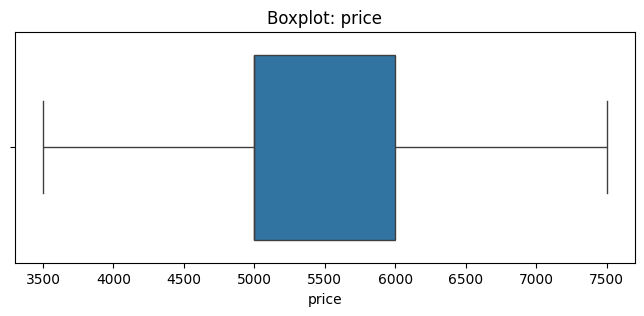

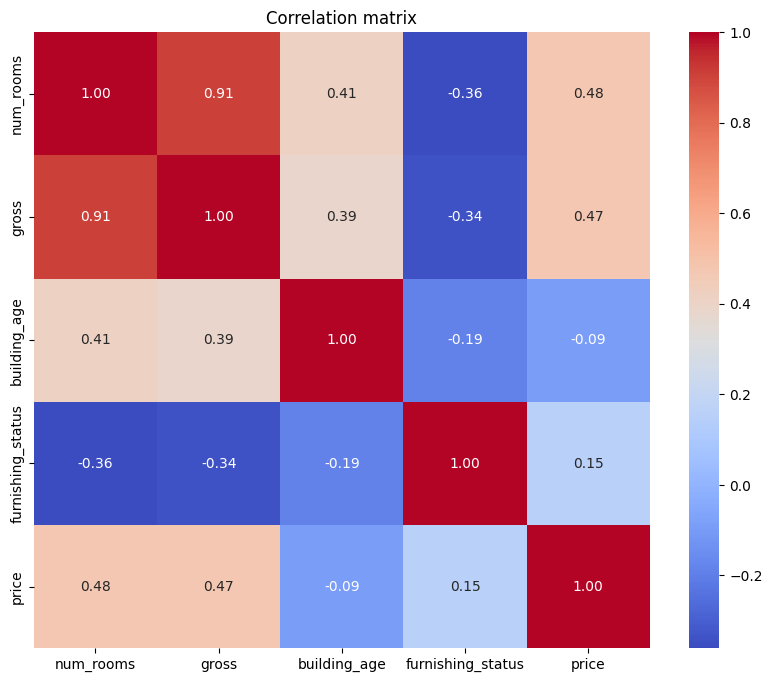

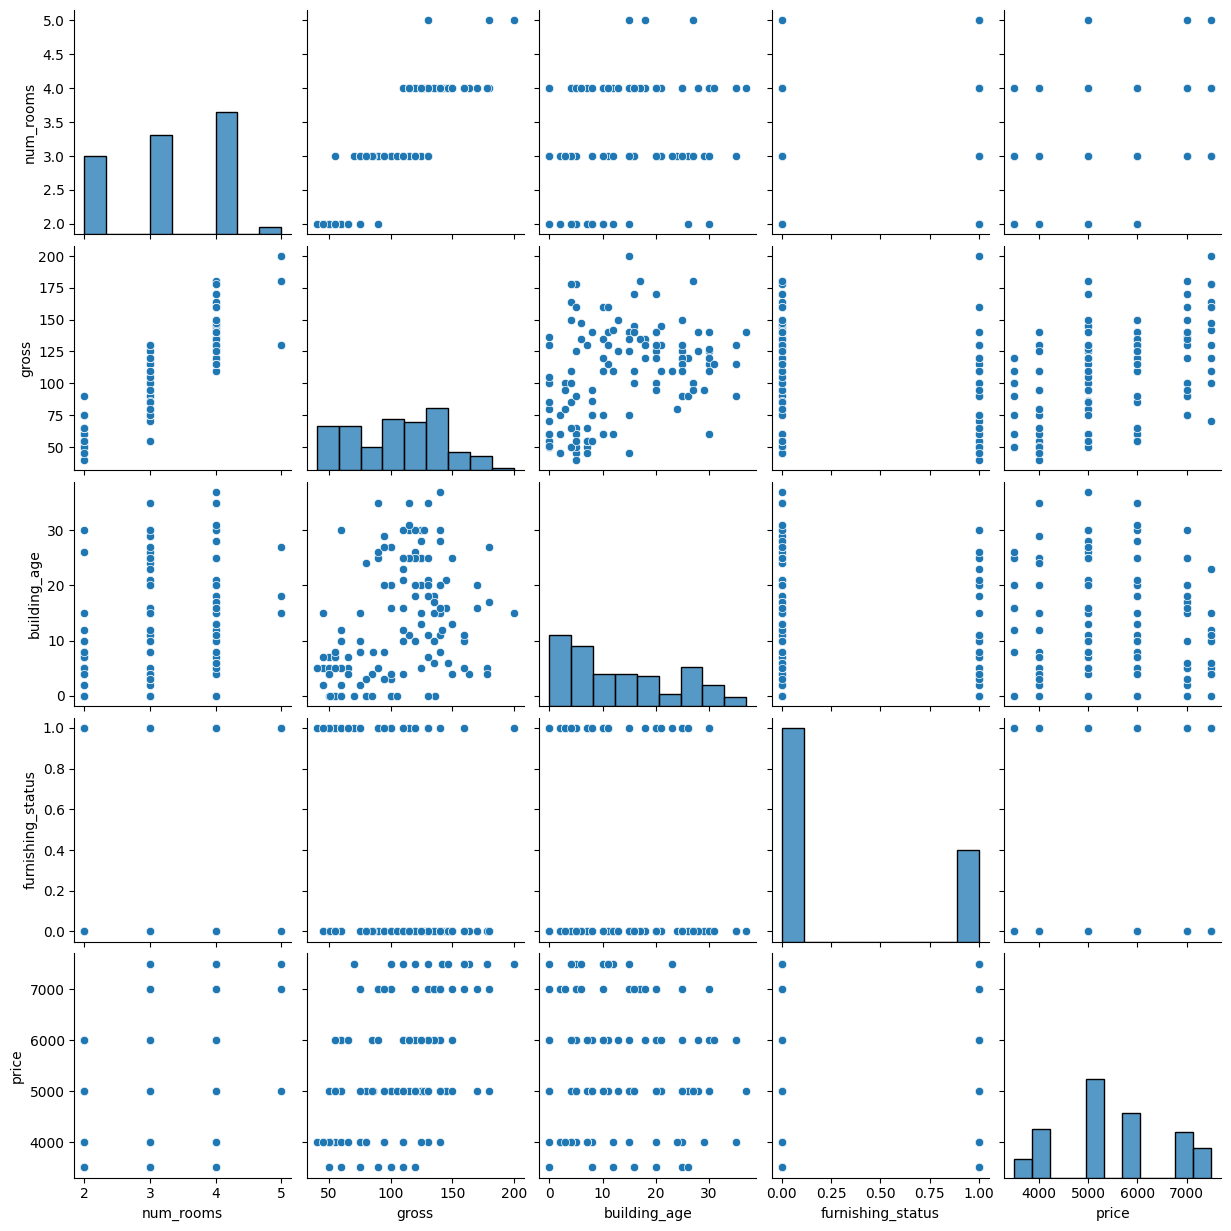

In [3]:
# Visualizations: distributions, boxplots, correlations
numeric = df_clean.select_dtypes(include=[np.number])
print('Numeric columns:', numeric.columns.tolist())

# 1) Histograms for numeric columns (auto layout)
n = min(12, len(numeric.columns))
if n>0:
    numeric.iloc[:, :n].hist(figsize=(3*n,4), bins=30)
    plt.tight_layout()
    plt.show()

# 2) Boxplots for top 6 numeric cols
top = numeric.columns[:6] if len(numeric.columns)>0 else []
for c in top:
    plt.figure(figsize=(8,3))
    sns.boxplot(x=df_clean[c])
    plt.title(f'Boxplot: {c}')
    plt.show()

# 3) Correlation heatmap (Pearson)
if numeric.shape[1] > 1:
    corr = numeric.corr()
    plt.figure(figsize=(10,8))
    sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', square=True)
    plt.title('Correlation matrix')
    plt.show()

# 4) Pairplot sample (be careful with many rows)
if numeric.shape[1] <= 6 and len(df_clean) <= 2000:
    sns.pairplot(numeric.dropna().sample(min(500, len(numeric))))
    plt.show()

In [6]:
# Save cleaned dataset to CSV so you can use it downstream
out_path = 'dataset_cleaned.csv'
df_clean.to_csv(out_path, index=False)
print('Saved cleaned CSV to', out_path)

# Provide a quick sample of cleaned data
df_clean.describe(include='all').transpose()

Saved cleaned CSV to dataset_cleaned.csv


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
location,133,3,merkez,74,NaN,NaN,NaN,NaN,NaN,NaN,NaN
num_rooms,133.0,NaN,NaN,NaN,3.18797,0.845222,2.0,2.0,3.0,4.0,5.0
gross,133.0,NaN,NaN,NaN,105.631579,37.440958,40.0,75.0,110.0,135.0,200.0
building_age,133.0,NaN,NaN,NaN,13.421053,10.221198,0.0,5.0,11.0,21.0,37.0
floor_type,133,4,intermediate,101,NaN,NaN,NaN,NaN,NaN,NaN,NaN
furnishing_status,133.0,NaN,NaN,NaN,0.300752,0.460319,0.0,0.0,0.0,1.0,1.0
price,133.0,NaN,NaN,NaN,5507.518797,1212.287098,3500.0,5000.0,5000.0,6000.0,7500.0


## Install required libraries
Open PowerShell in the project folder and run the following command to install libraries used in this notebook:

```powershell
pip install -r requirements.txt
```

If you prefer to install manually, these are the libraries used: `pandas`, `numpy`, `matplotlib`, `seaborn`, `plotly`, `scikit-learn`, `missingno`, `jupyterlab`, `streamlit`.